<a href="https://colab.research.google.com/github/tkhan3/Plate_detect_and_recognize/blob/master/number_plate_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!pip install 'h5py==2.10.0' --force-reinstall
!pip install tensorflow==1.14.0
!pip install keras==2.3.1

  Using cached https://files.pythonhosted.org/packages/60/06/cafdd44889200e5438b897388f3075b52a8ef01f28a17366d91de0fa2d05/h5py-2.10.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/14/32/d3fa649ad7ec0b82737b92fefd3c4dd376b0bb23730715124569f38f3a08/numpy-1.19.5-cp36-cp36m-manylinux2010_x86_64.whl
ERROR: nbclient 0.5.1 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Found existing installation: numpy 1.19.5
  

In [1]:
import tensorflow as tf
import cv2
import keras

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
print (tf.__version__)
print (cv2.__version__)
print (keras.__version__)

1.14.0
4.1.2
2.3.1


In [4]:
!ls

Plate_detect_and_recognize  sample_data


In [5]:
!rm -r Plate_detect_and_recognize

In [6]:
!git clone https://github.com/tkhan3/Plate_detect_and_recognize.git

Cloning into 'Plate_detect_and_recognize'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 198 (delta 1), reused 19 (delta 1), pack-reused 177
Receiving objects: 100% (198/198), 96.07 MiB | 28.87 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [7]:
!ls

Plate_detect_and_recognize  sample_data


In [8]:
%cd Plate_detect_and_recognize

/content/Plate_detect_and_recognize


In [9]:
!ls

 dataset_characters.zip
 figures
 IndianPlates
 LICENSE
 license_character_classes.npy
 License_character_recognition_weight.h5
 local_utils.py
 MobileNets_character_recognition.json
'[Part 1]License_plate_detection.ipynb'
'[Part 2]Plate_character_segmentation_with_OpenCV.ipynb'
'[Part 3]End-to-end.ipynb'
'[Part 3]Train_license_character_recognition.ipynb'
 Plate_examples
 README.md
 wpod-net.h5
 wpod-net.json


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob

In [11]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [12]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

In [13]:
# forward image through model and return plate's image and coordinates
# if error "No Licensese plate is founded!" pop up, try to adjust Dmin
def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.4)
    return LpImg, cor

In [14]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)


Loading model successfully...


Found 14 images...


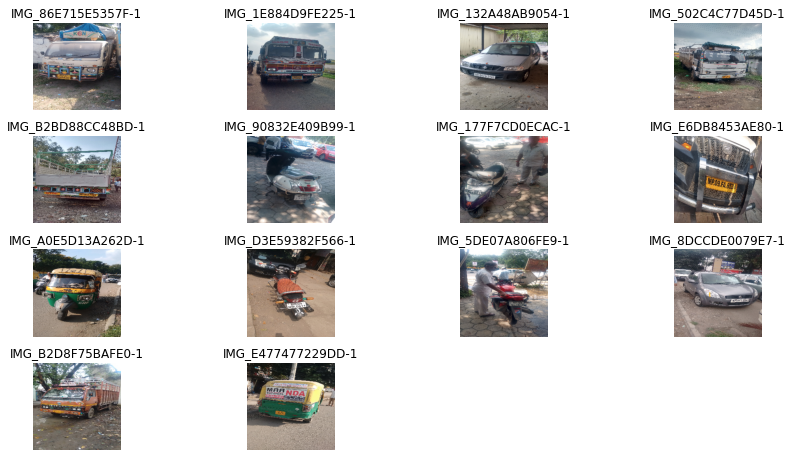

In [23]:
# Create a list of image paths 
image_paths = glob.glob("IndianPlates/*.jpeg")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 4
rows = 5
fig_list = []
number_of_images = len(image_paths)
for i in range(number_of_images):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

Detect 1 plate(s) in IMG_132A48AB9054-1
Coordinate of plate(s) in image: 
 [array([[2.80926898e+02, 7.28607580e+02, 7.27852690e+02, 2.80172008e+02],
       [1.88478871e+03, 2.00477638e+03, 2.11613589e+03, 1.99614823e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])]


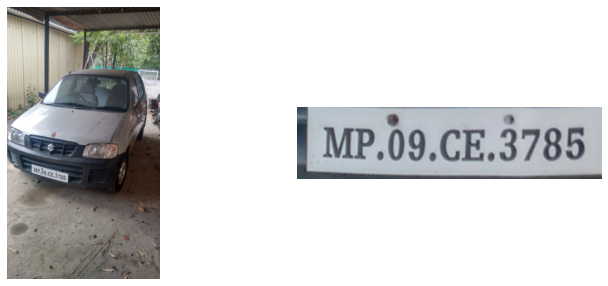

In [24]:
# forward image through model and return plate's image and coordinates
# if error "No Licensese plate is founded!" pop up, try to adjust Dmin
def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Obtain plate image and its coordinates from an image
test_image = image_paths[2]
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

#plt.savefig("part1_result.jpg",dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


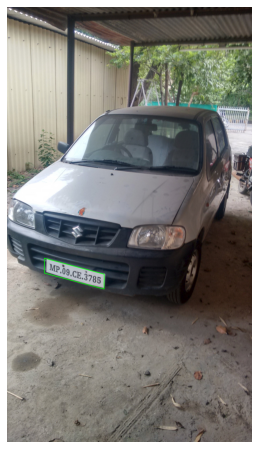

In [25]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

Number Plate Can't be detected IMG_86E715E5357F-1
Number Plate Can't be detected IMG_B2D8F75BAFE0-1


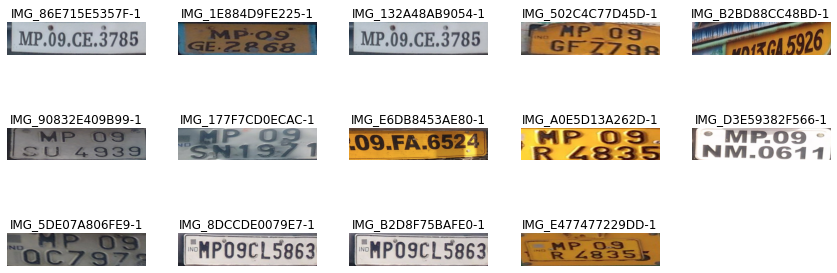

In [27]:
# Viualize all obtained plate images 
fig = plt.figure(figsize=(12,6))
cols = 5
rows = 4
fig_list = []

for i in range(number_of_images):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    try:
      LpImg,_ = get_plate(image_paths[i])
    except AssertionError:
      print ("Number Plate Can't be detected %s"%title)
    plt.axis(False)
    plt.imshow(LpImg[0])

plt.tight_layout(True)
plt.show()